In [2]:
import os, requests, gzip, hashlib
import numpy as np
import matplotlib.pyplot as plt

from atomic_graph.engine import Value

In [3]:
def load_mnist():
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    x_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:]
    y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
    x_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[0x10:]
    y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    return (x_train, y_train), (x_test, y_test), class_names

def fetch(url):
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
    else:
        with open(filepath, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [4]:
(x_train, y_train), (x_test, y_test), class_names = load_mnist()

print('Training Dataset Shape:', x_train.shape)
print('Number of training images:', x_train.shape[0])
print("Number of training labels:", (len(y_train)))
print('Number of test images:', x_test.shape[0])
print("Number of test labels:", (len(y_test)))

Training Dataset Shape: (60000, 28, 28, 1)
Number of training images: 60000
Number of training labels: 60000
Number of test images: 10000
Number of test labels: 10000


In [5]:
def calculate_loss(X,Y,W):
    loss = -(1 / X.shape[0]) * np.sum(np.sum(Y * np.log(np.exp(np.matmul(X, W)) / np.sum(np.exp(np.matmul(X, W)), axis=1)[:, None]), axis=1))
    return loss

In [6]:
def to_categorical(y, num_classes):
    """ 1-hot encoding """
    y = np.array(y, dtype="int")
    return np.eye(num_classes, dtype='uint8')[y]

In [7]:
train_images = x_train.reshape(60000, 784)
test_images = x_test.reshape(10000, 784)
train_idx = to_categorical(y_train, len(class_names))

In [8]:
Wb = Value(np.random.randn(x_train[0].shape[0] * x_train[0].shape[1], len(class_names)))
Wb.shape()

(784, 10)

In [9]:
batch_size = 32
epochs = 20000

for i in range(epochs):
    ri = np.random.permutation(train_images.shape[0])[:batch_size]
    Xb, Yb = Value(train_images[ri]), Value(train_idx[ri])

    y_pred = Xb.matmul(Wb)
    
    probs = y_pred.softmax()
    log_probs = probs.log()

    Zb = Yb * log_probs

    cost = Zb.reduce_sum(axis=1).reduce_sum()  #Cross-entropy
    cost.backward()

    if i % 1000 == 0:
        loss = calculate_loss(train_images, train_idx, Wb.data)
        print(f'Epoch: {i} | Loss: {loss:.5f}')

    Wb.data = Wb.data + 0.01 * Wb.grad
    Wb.grad = 0

Epoch: 0 | Loss: 14.66962
Epoch: 1000 | Loss: 0.72216
Epoch: 2000 | Loss: 0.54474
Epoch: 3000 | Loss: 0.49245
Epoch: 4000 | Loss: 0.46259
Epoch: 5000 | Loss: 0.42223
Epoch: 6000 | Loss: 0.39641
Epoch: 7000 | Loss: 0.39460
Epoch: 8000 | Loss: 0.36867
Epoch: 9000 | Loss: 0.36229
Epoch: 10000 | Loss: 0.36374
Epoch: 11000 | Loss: 0.34662
Epoch: 12000 | Loss: 0.35589
Epoch: 13000 | Loss: 0.34033
Epoch: 14000 | Loss: 0.32441
Epoch: 15000 | Loss: 0.32178
Epoch: 16000 | Loss: 0.33423
Epoch: 17000 | Loss: 0.31201
Epoch: 18000 | Loss: 0.31384
Epoch: 19000 | Loss: 0.33357


In [10]:
def predict(x_in, W):
    pred = x_in.matmul(W)
    return pred.data.argmax()

Ground truth: 6
Prediction: 6


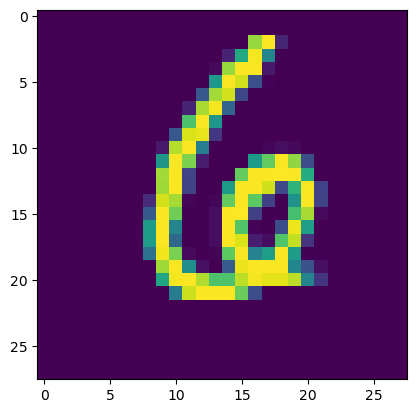

In [11]:
index = 123
print("Ground truth:", y_test[index])
plt.imshow(x_test[index])

print("Prediction:", predict(Value(test_images[index]), Wb))